In [ ]:
try:
    import procgen_tools
except ImportError:
    get_ipython().run_line_magic(
        magic_name="pip",
        line="install -U git+https://github.com/ulissemini/procgen-tools",
    )

from procgen_tools.utils import setup

setup()  # create directory structure and download data

from procgen_tools.imports import *
from procgen_tools import maze, visualization, models, patch_utils
from typing import Tuple, Dict, List, Optional, Union
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tqdm

SAVE_DIR = "playground/visualizations"
AX_SIZE = 6

cheese_channels = [7, 8, 42, 44, 55, 77, 82, 88, 89, 99, 113]
effective_channels = [8, 55, 77, 82, 88, 89, 113]

In [ ]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
vf = visualization.vector_field(venv, hook.network)
start = (0, 0)
end = (0, 3)
prob = maze.geometric_probability_path(start, end, vf)
print(
    f"The geometric average probability from {start} to {end} is {prob:0.3f}"
)

# Showing mean probability of reaching each part of the maze

Heatmap of original policy


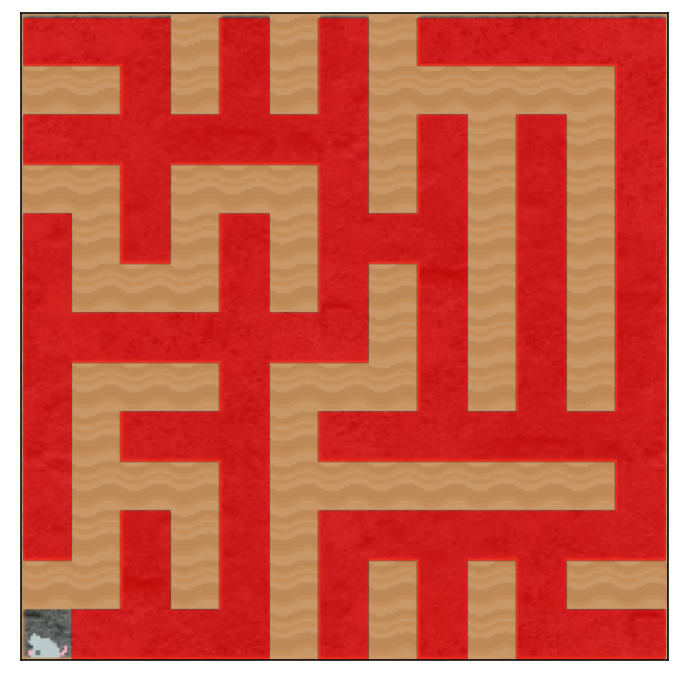

100%|██████████| 97/97 [02:33<00:00,  1.58s/it]


Change in probability from original policy


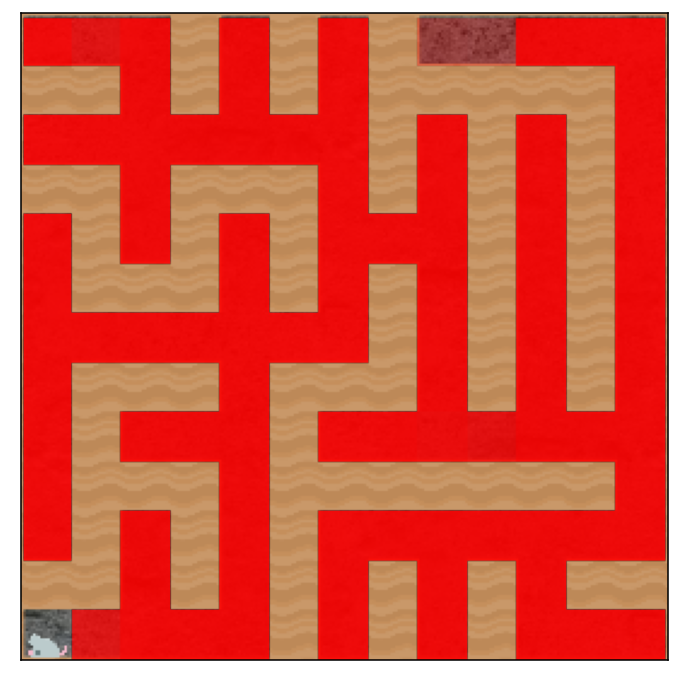

In [113]:
def show_retarget_heatmap(
    seed: int, remove_cheese: bool = True
) -> pd.DataFrame:
    """Show a heatmap over the maze using matplotlib.

    Args:
        seed: Seed of the maze
    """
    venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
    new_venv = maze.remove_cheese(venv) if remove_cheese else venv
    normal_probs: np.ndarray = vf_heatmap(new_venv, hook)
    visualization.show_grid_heatmap(
        venv=venv, heatmap=normal_probs, ax_size=AX_SIZE, mode="human", size=1
    )
    print("Heatmap of original policy")
    plt.show()

    data = retarget_heatmap(
        new_venv,
        hook,
        channels=effective_channels,
        magnitude=2.3,  # 5.6,
        remove_cheese=True,
        compute_normal=True,
    )
    data["retarget_prob"] = data["retarget_prob"].apply(
        np.ravel
    )  # Flatten the (1,)-shaped tuples in this column
    data["ratio"] = data["retarget_prob"] / data["normal_prob"]
    heatmap = data.pivot(index="row", columns="col", values="ratio")

    print("Change in probability from original policy")

    visualization.show_grid_heatmap(
        venv=venv,
        heatmap=heatmap.values,
        ax_size=AX_SIZE,
        mode="human",
        size=0.5,
        alpha=0.9,
    )

    return data


data = show_retarget_heatmap_interactive(0)

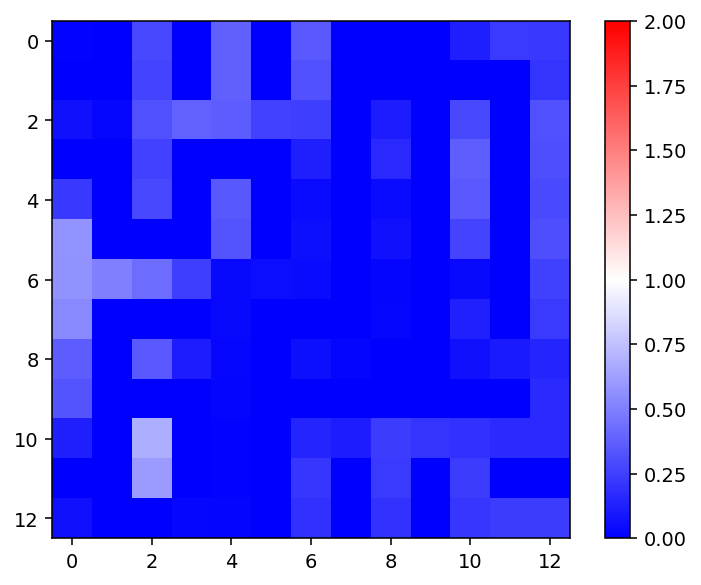

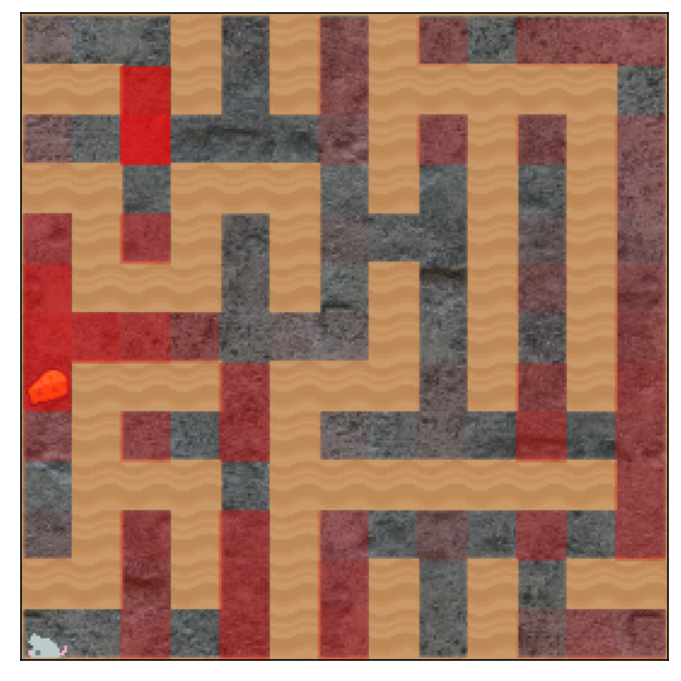

In [136]:
data["diff"] = data["retarget_prob"] - data["normal_prob"]

heatmap = data.pivot(index="row", columns="col", values="diff")
# Turn nans into 0s
heatmap = heatmap.fillna(-10)
heatmap = heatmap.applymap(lambda x: x[0] if type(x) == np.ndarray else x)
# Flip the heatmap so that the origin is in the bottom left
heatmap = heatmap.iloc[::-1]
# Blue negative, red positive colorbar
# Show in plotly
# fig = px.imshow(heatmap.values, zmin=0, zmax=3)
# fig.show()

plt.imshow(heatmap.values, cmap="bwr", vmin=0, vmax=2)
plt.colorbar()
plt.show()

visualization.show_grid_heatmap(
    venv=venv,
    heatmap=heatmap.values,
    ax_size=AX_SIZE,
    mode="human",
    alpha=0.9,
)

In [ ]:
# Save the pandas dataframe
data.to_pickle(
    os.path.join("experiments/statistics/data", "maze_retarget.pkl")
)

In [108]:
@interact
def apply_all_cheese_patches(
    seed=IntSlider(min=0, max=100, step=1, value=0),
    value=FloatSlider(min=-10, max=10, step=0.1, value=2.3),
    row=IntSlider(min=0, max=15, step=1, value=5),
    col=IntSlider(min=0, max=15, step=1, value=5),
    channel_list=Dropdown(
        options=[effective_channels, cheese_channels], value=effective_channels
    ),
    mask_channels=Checkbox(value=False),
):
    render_padding = False
    padding = maze.get_padding(grid=maze.get_inner_grid_from_seed(seed))

    combined_patch = patch_utils.combined_pixel_patch(
        layer_name=default_layer,
        value=value,
        coord=(row, col),
        channels=channel_list,
        default=-0.2 if mask_channels else None,
    )

    venv = patch_utils.get_cheese_venv_pair(seed=seed)
    fig, axs, info = patch_utils.compare_patched_vfields(
        venv,
        combined_patch,
        hook,
        render_padding=render_padding,
        ax_size=AX_SIZE,
    )

    # Draw a red pixel at the location of the patch
    visualization.plot_dots(
        axs[1:], (row, col), hidden_padding=0 if render_padding else padding
    )  # Note this can go out of bounds if render_padding is False
    plt.show()

    button = visualization.create_save_button(
        prefix=(
            f'{SAVE_DIR}/{"all" if channel_list == cheese_channels else "effective"}_cheese_patches_'
        ),
        fig=fig,
        descriptors=defaultdict(
            seed=seed,
            value=value,
            row=row,
            col=col,
            mask_channels=mask_channels,
        ),
    )
    display(button)

interactive(children=(IntSlider(value=0, description='seed'), FloatSlider(value=2.3, description='value', max=…

# Compare with retargeting by moving the cheese around 

In [ ]:
def cheese_at_square(venv, coord: Tuple[int, int]) -> float:
    """Returns the probability of navigating to a square, given that
    the cheese is placed at the given square."""
    grid: np.ndarray = maze.state_from_venv(venv).inner_grid()
    padding: int = maze.get_padding(grid)
    new_coord: Tuple[int, int] = (coord[0] + padding, coord[1] + padding)
    moved_venv = maze.move_cheese(venv, new_coord)
    vf: Dict = visualization.vector_field(moved_venv, hook.network)
    return maze.geometric_probability_path((0, 0), coord, vf)